In [1]:
run = 'densenet_03_128x128'

##### 00. Load Packages

In [2]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

def get_available_cpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'CPU']

gpu_list = get_available_gpus()
cpu_list = get_available_cpus()

if len(gpu_list)>0:
    device_use = str(gpu_list[-1])
    print 'Using GPU : ' + device_use
else:
    device_use = str(cpu_list[-1])
    print 'Using CPU : ' + device_use

Using GPU : /gpu:1


In [3]:
%pylab inline


import seaborn as sns
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [4]:
import glob as glob
import cv2 as cv2
from tqdm import tqdm

In [5]:
import keras
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Dropout, Activation
from keras.layers import Lambda, Conv2D, MaxPooling2D, Dense

from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


##### 00. Define functions

In [6]:
def get_image(image_path,size):
    
    x = cv2.imread(image_path)
    x = cv2.resize(x,size,cv2.INTER_NEAREST)
    
    return(x)

def get_labels(image_path):
    
    image_id = image_path.split('/')[-1]
    image_number = image_id.split('.')[0]
    values = train_output.loc[np.int(image_number)].values
    
    return(values)

In [7]:
train_files = glob.glob('../01.data/extracted/images_training_rev1/*.jpg')
test_files = glob.glob('../01.data/extracted/images_test_rev1/*.jpg')

In [8]:
y_path = '../01.data/extracted/training_solutions_rev1.csv'
train_output = pd.read_csv(y_path,index_col='GalaxyID')
train_output.sort_index(inplace=True)

In [9]:
num_classes = 37
epochs = 1500


input_size = (128,128)
img_rows, img_cols = input_size
img_channels = 3
observations,output_classes = train_output.shape

In [116]:
from gc import collect

n = len(train_files)

train_x = np.zeros((n,img_rows,img_cols,img_channels),dtype=np.uint8)
train_y = np.zeros((n,num_classes),dtype=np.float128)

for current_id in tqdm(range(n),miniters=1000):
    
    if current_id%1000==0:
        collect()
        
    current_path = train_files[current_id]
    
    current_image  = np.array(get_image(current_path,input_size))
    current_labels = get_labels(current_path)
    
    train_x[current_id] = current_image
    train_y[current_id] = current_labels
    
    
train_y_expanded = np.expand_dims(np.expand_dims(train_y,1),1)

100%|██████████| 61578/61578 [29:13<00:00, 35.11it/s]  


In [117]:
print('train_x shape:', train_x.shape)
print('train_y shape:', train_y.shape)
print('train_y shape:', train_y_expanded.shape)

('train_x shape:', (61578, 128, 128, 3))
('train_y shape:', (61578, 37))
('train_y shape:', (61578, 1, 1, 37))


In [118]:
from DenseNet import densenet

In [123]:
K.clear_session()

model = densenet.DenseNet(classes=num_classes,
                          input_shape=(img_rows,img_cols,img_channels),
                          weights=None,
                          depth=34,
                          include_top=False,
                          growth_rate=4,
                          bottleneck=False)

In [124]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
initial_conv2D (Conv2D)      (None, 128, 128, 16)      432       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 4)       576       
_________________________________________________________________
concatenate_1 (Concatenate)  (None, 128, 128, 20)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 20)      80        
__________

In [125]:
len(model.layers)

135

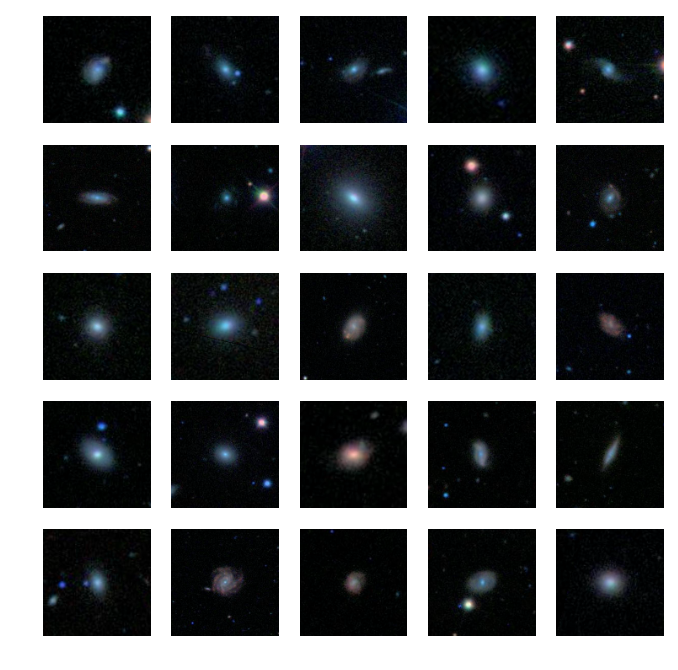

In [126]:
np.random.seed(42)
img_to_plot = 25
samples = np.random.randint(0,1000,img_to_plot)
a = train_x[samples]

plt.figure(figsize=(8,8))
for img_num in range(img_to_plot):
    
    plt.subplot(5,5,img_num+1)
    plt.grid('off')
    plt.imshow((a[img_num]));
    plt.axis('off')

In [127]:
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras_tqdm import TQDMNotebookCallback

tb = TensorBoard(
        log_dir='../tensorboard/'+run+'/',
        write_graph=True,
        write_images=True
    )

mc = ModelCheckpoint(filepath = '../05.model/'+run+'.h5',
                     save_best_only = True)

ec = EarlyStopping(monitor='val_loss',
                   patience=5,
                   mode='auto')

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=3,
                              min_lr=1e-15)

tqnc = TQDMNotebookCallback()

In [128]:
from keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
                                rescale=1.0/255,
                                rotation_range=180,
                                vertical_flip=True,
                                horizontal_flip=True,
                                data_format='channels_last',
                                
)

validation_datagen = ImageDataGenerator(
                                rescale=1.0/255,
                                data_format='channels_last'
)

test_datagen = ImageDataGenerator(
                                rescale=1.0/255,
                                data_format='channels_last'
)

In [129]:
batch_size = 50
train_steps = 2*train_x.shape[0]/batch_size
validation_steps = 0.1 * train_steps

In [130]:
train_generator = train_datagen.flow(
                                    x=train_x,
                                    y=train_y,
                                    batch_size=batch_size
)

validation_generator = validation_datagen.flow(
                                            x=train_x,
                                            y=train_y,
                                            batch_size=batch_size
)


#test_generator = test_datagen.flow_from_directory(directory='../01.data/',
#                                                  shuffle=False
#)

In [131]:
def custom_processing(img_path,img_size):
    
    img_x = get_image(img_path,img_size)
    img_y = get_labels(img_path)
    
    yield img_x,img_y
    
def custom_generator(input_paths,
                     batch_size,
                     img_rows=img_rows,
                     img_cols=img_cols,
                     img_channels=img_channels,
                     n_classes=output_classes,
                     input_size=input_size):
    
    # Create empty arrays to contain batch of features and labels#
    
    batch_features = np.zeros((batch_size,img_rows,img_cols,img_channels))
    batch_labels = np.zeros((batch_size,n_classes))
    
    
    while True:
        
        # Generate batch
        
        for i in range(batch_size):
            
            # choose random index in features
            index= random.choice(len(input_paths),1)
            batch_features[i],batch_labels[i] = custom_processing(input_paths[index],input_size)
            
        yield batch_features, batch_labels

def generator(train_files, labels, batch_size):
    
    # Create empty arrays to contain batch of features and labels#
    batch_features = np.zeros((batch_size, img_rows,img_cols,img_channels))
    batch_labels = np.zeros((batch_size,num_classes))

    while True:
        for i in range(batch_size):
            
            # choose random index in features
            index= random.choice(len(train_files),1)
            
            feature_files = train_files[index]
            feature_images = np.array([
                                       cv2.imread(image_path) 
                                       for image_path in feature_files
                                      ])
            batch_features[i] = some_processing(features)
            yield batch_features, batch_labels

In [132]:
def rmse(y_true, y_pred):
    
        return K.sqrt(keras.losses.mse(y_true,y_pred)) 

In [ ]:
with tf.device(device_use):

    model.compile(loss='mape',
                  metrics=[rmse],
                  optimizer=keras.optimizers.adam(lr=1e-2)
                 )
    
    loss_history = model.fit_generator(
                                    generator=train_generator,
                                    validation_data=validation_generator,
                                    epochs=epochs,
                                    steps_per_epoch=train_steps,
                                    validation_steps=validation_steps,
                                    callbacks=[tb,mc,ec,reduce_lr,tqnc],
                                    max_q_size=2,
                                    verbose=1
                )


loss_df = pd.DataFrame(loss_history.history)
loss_df.to_csv('../03.plots/losses/augmented_loss_df'+run+'.csv',
                   index=False)

The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


Epoch 1/1500
 969/2463 [==========>...................] - ETA: 2379s - loss: 75994.1602 - rmse: 0.2668

model.compile(loss='mse',
              optimizer=keras.optimizers.adam(lr=1e-2)
             )

with tf.device(device_use):
    
    loss_history = model.fit(x=train_x,
                             y=train_y,
                             batch_size=10,
                             validation_split=0.1,
                             callbacks=[tb,mc,ec,reduce_lr,tqnc],
                             epochs=epochs,
                             verbose=1
                            )


loss_df = pd.DataFrame(loss_history.history)
loss_df.to_csv('../03.plots/losses/augmented_loss_df'+run+'_2.csv',
                   index=False)

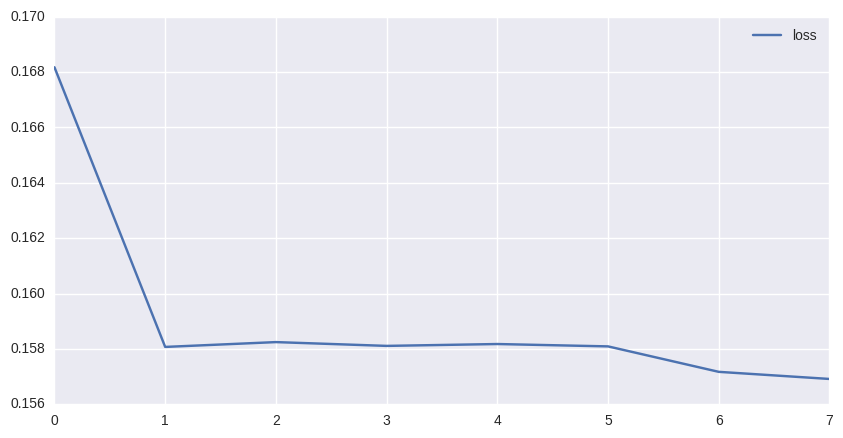

In [106]:
loss_df.plot(y=['loss'],
             figsize=(10,5));

In [51]:
loss_df.tail()

,loss,lr,val_loss
4,0.025639,0.010,0.031957
5,0.025629,0.010,0.032407
6,0.025672,0.010,0.031864
7,0.025124,0.001,0.029742
8,0.024993,0.001,0.527068


pd.concat([loss_df_original,loss_df]).reset_index(drop=True).plot(secondary_y=['lr'],figsize=(10,5));

#### Test data

In [235]:
out = {}

with tf.device(device_use):  
    for file_path in tqdm(test_files):
        galaxy_id = file_path.split('/')[-1].split('.')[0]
        galaxy_img = np.expand_dims(cv2.resize(cv2.imread(file_path),
                                               input_size),
                                    axis=0)*1.0/255
        galaxy_pred = model.predict(galaxy_img-30).flatten()

        out[galaxy_id] = galaxy_pred

100%|██████████| 79975/79975 [47:26<00:00, 28.27it/s]  


In [236]:
columns = pd.read_csv(y_path,
                      index_col='GalaxyID',
                      nrows=0)

test_results = pd.DataFrame.from_dict(data = out,
                                      orient='index')
test_results.index.name = 'GalaxyID'
test_results.columns = columns.columns

In [237]:
test_results.to_csv('../04.results/submission'+run+'.csv',
                    index_label='GalaxyID')

In [238]:
model.save('../05.model/00.'+run+'.h5',include_optimizer=False)